In [1]:
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
model_metadata = pd.read_csv("../../config/models.csv")
palette = model_metadata.set_index("description")["color"].to_dict()
model_renaming = model_metadata.set_index("name")["description"].to_dict()
model_metadata

,name,description,color
0,CADD,CADD,C0
1,GPN-MSA,GPN-MSA,C1
2,Borzoi,Borzoi,C2
3,Enformer,Enformer,C3
4,GPN,gLM-Promoter,C4
5,NucleotideTransformer,NT,C5
6,HyenaDNA,HyenaDNA,C6
7,Caduceus,Caduceus,C7
8,CADD+GPN-MSA+Borzoi,Ensemble,C8


In [74]:
#dataset = "mendelian_traits_all"
dataset = "complex_traits_all"
subset = "all"

#subset = "maf_0.00_0.05"
#subset = "maf_0.05_0.50"
#subset = "maf_0.0_0.1"
#subset = "maf_0.1_0.2"
#subset = "maf_0.2_0.3"
#subset = "maf_0.3_0.4"
#subset = "maf_0.4_0.5"

features = [
    "CADD",
    "GPN-MSA_LLR",
    "GPN-MSA_absLLR",

    "GPN_LLR",
    "GPN_absLLR",
]

base_dir = f"../../results/dataset/{dataset}"
V = pl.read_parquet(f"{base_dir}/test.parquet")
for feature in features:
    df = pl.read_parquet(f"{base_dir}/features/{feature}.parquet")
    df.columns = [f"{feature}_{col}" for col in df.columns]
    V = pl.concat([V, df], how="horizontal")
subset_df = pl.read_parquet(f"{base_dir}/subset/{subset}.parquet")
V = subset_df.join(V, on=["chrom", "pos", "ref", "alt"], how="left")
V

chrom,pos,ref,alt,pip,trait,label,maf,ld_score,consequence,CADD_RawScore,GPN-MSA_LLR_score,GPN-MSA_absLLR_score,GPN_LLR_score,GPN_absLLR_score
str,i64,str,str,f64,str,bool,f64,f64,str,f32,f32,f32,f32,f32
"""1""",758351,"""A""","""G""",0.0,"""""",false,0.11581,80.222,"""intron_variant""",0.745346,-0.050781,0.050781,-0.114136,0.114136
"""1""",772142,"""G""","""C""",0.0,"""""",false,0.097076,73.052,"""intron_variant""",-0.382612,-1.642578,1.642578,-1.837891,1.837891
"""1""",782207,"""G""","""A""",0.0,"""""",false,0.015778,12.172,"""intron_variant""",0.207167,0.259766,0.259766,-1.181641,1.181641
"""1""",787949,"""A""","""T""",0.0,"""""",false,0.0017441,5.0762,"""intron_variant""",0.327236,-3.337891,3.337891,-0.032837,0.032837
"""1""",794707,"""T""","""C""",0.0,"""""",false,0.056288,50.019,"""intron_variant""",0.611349,-1.332031,1.332031,0.281006,0.281006
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""22""",50791377,"""T""","""C""",0.0,"""""",false,0.072962,59.296,"""intron_variant""",0.361089,-0.30957,0.30957,-0.782227,0.782227
"""22""",50792792,"""A""","""G""",0.0,"""""",false,0.05375,43.457,"""intron_variant""",1.123357,-0.059998,0.059998,0.120972,0.120972
"""22""",50795771,"""T""","""C""",0.0,"""""",false,0.000132,45.399,"""intron_variant""",-0.395607,-1.624023,1.624023,-2.128906,2.128906


In [75]:
sorted_V = {
    "CADD": V.sort("CADD_RawScore", descending=True),

    #"GPN-MSA": V.sort("GPN-MSA_LLR_score", descending=False),
    #"gLM-Promoter": V.sort("GPN_LLR_score", descending=False),

    "GPN-MSA": V.sort("GPN-MSA_absLLR_score", descending=True),
    "gLM-Promoter": V.sort("GPN_absLLR_score", descending=True),
}

In [44]:
n_pos = V["label"].sum()
k = n_pos

In [45]:
res = []
for model, df in sorted_V.items():
    n = df.head(k)["label"].sum()
    precision_at_k = n / k
    res.append([
        model,
        k,
        n,
        precision_at_k,
    ])
res = pd.DataFrame(res, columns=["model", "k", "n_pos@k", "precision@k"])
res = res.sort_values("precision@k", ascending=False)
res

,model,k,n_pos@k,precision@k
1,GPN-MSA,339,51,0.150442
0,CADD,339,5,0.014749
2,gLM-Promoter,339,1,0.002950


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


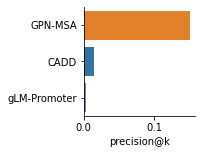

In [46]:
plt.figure(figsize=(2,2))
g = sns.barplot(
    data=res,
    y="model",
    x="precision@k",
    palette=palette,
)
g.set(
    ylabel="",
)
sns.despine();

In [47]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score, PrecisionRecallDisplay

Text(0, 0.5, 'Precision')

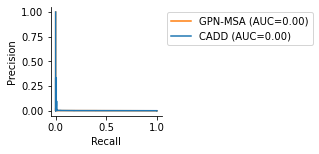

In [85]:
#k = 1 * n_pos
#k = 10 * n_pos
k = 100 * n_pos
fig, ax = plt.subplots(figsize=(2,2))
df = sorted_V["GPN-MSA"].head(k)
AUC = average_precision_score(df["label"], -df["GPN-MSA_LLR_score"])
PrecisionRecallDisplay.from_predictions(
    df["label"], -df["GPN-MSA_LLR_score"], label=f"GPN-MSA ({AUC=:.2f})",
    ax=ax, color=palette["GPN-MSA"],
)
df = sorted_V["CADD"].head(k)
AUC = average_precision_score(df["label"], df["CADD_RawScore"])
PrecisionRecallDisplay.from_predictions(
    df["label"], df["CADD_RawScore"], label=f"CADD ({AUC=:.2f})",
    ax=ax, color=palette["CADD"],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine()
plt.xlabel("Recall")
plt.ylabel("Precision")

Text(0, 0.5, 'Precision')

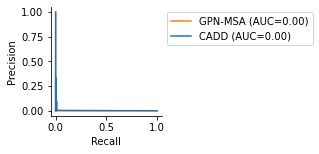

In [86]:
n_pos = V["label"].sum()
#k = 1 * n_pos
#k = 10 * n_pos
k = 100 * n_pos
fig, ax = plt.subplots(figsize=(2,2))
df = sorted_V["GPN-MSA"].head(k)
AUC = average_precision_score(df["label"], df["GPN-MSA_absLLR_score"])
PrecisionRecallDisplay.from_predictions(
    df["label"], df["GPN-MSA_absLLR_score"], label=f"GPN-MSA ({AUC=:.2f})",
    ax=ax, color=palette["GPN-MSA"],
)
df = sorted_V["CADD"].head(k)
AUC = average_precision_score(df["label"], df["CADD_RawScore"])
PrecisionRecallDisplay.from_predictions(
    df["label"], df["CADD_RawScore"], label=f"CADD ({AUC=:.2f})",
    ax=ax, color=palette["CADD"],
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine()
plt.xlabel("Recall")
plt.ylabel("Precision")

In [83]:
sorted_V["GPN-MSA"].head(k)["label"].sum()

33

In [84]:
sorted_V["CADD"].head(k)["label"].sum()

30